# Housing Prices Competition for Kaggle Learn Users

Apply what you learned in the Machine Learning course on Kaggle Learn alongside others in the course

---
<a name="index"></a>

## Índice

1. [Bibliotecas e Módulos](#imports)
2. [Preparação e Visualização](#loading)
3. [Tratamentos e Transformações](#cleaning)
4. [Treinamentos e Validações](#training)
5. [Resultados e Conclusão](#results)

---
<a name="imports"></a>([Voltar ao Índice](#index))

## 1. Bibliotecas e Módulos

### 1.1 Bibliotecas externas

Instalações do gerenciador de pacotes [Mamba](https://mamba.readthedocs.io) e das bibliotecas [XGBoost](https://xgboost.readthedocs.io) (de acordo com a documentação do [Jupyter Docker Stacks](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/recipes.html#xgboost)) e [SciKeras](https://www.adriangb.com/scikeras) (para o uso do [Keras](https://keras.io) com [scikit-learn](https://scikit-learn.org)).

In [1]:
!mamba install --quiet --yes gcc && \
    mamba clean --all -f -y && \
    fix-permissions "${CONDA_DIR}" && \
    fix-permissions "/home/${NB_USER}"

!pip install --quiet --no-cache-dir xgboost && \
    fix-permissions "${CONDA_DIR}" && \
    fix-permissions "/home/${NB_USER}"

!pip install --quiet --no-cache-dir scikeras[tensorflow]


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.24.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Will remove 1 package cache(s).


### 1.2 Módulos

Todos os módulos (exceto XGBRegressor da bilbioteca XGBoost e KerasRegressor da biblioteca SciKeras) estão disponíveis usando a imagem Docker [jupyter/tensorflow-notebook](https://hub.docker.com/r/jupyter/tensorflow-notebook).

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from xgboost.sklearn import XGBRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

---
<a name="loading"></a>([Voltar ao Índice](#index))

## 2. Preparação  e Visualização

### 2.1 Importando *DataFrames* 

`train_data` é o *DataFrame* para treinamento.

`test_data` é o *DataFrame* para predição da solução.

`submission` é o *DataFrame* para o envio da solução.

In [3]:
train_data = pd.read_csv('data/train.csv', index_col='Id')
test_data = pd.read_csv('data/test.csv', index_col='Id')
submission = pd.read_csv('data/sample_submission.csv')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 2.2 Quantidade de dados dos atributos

Visualização da quantidade de dados em cada atributo. A linha vermelha representa 80% do total dos dados.

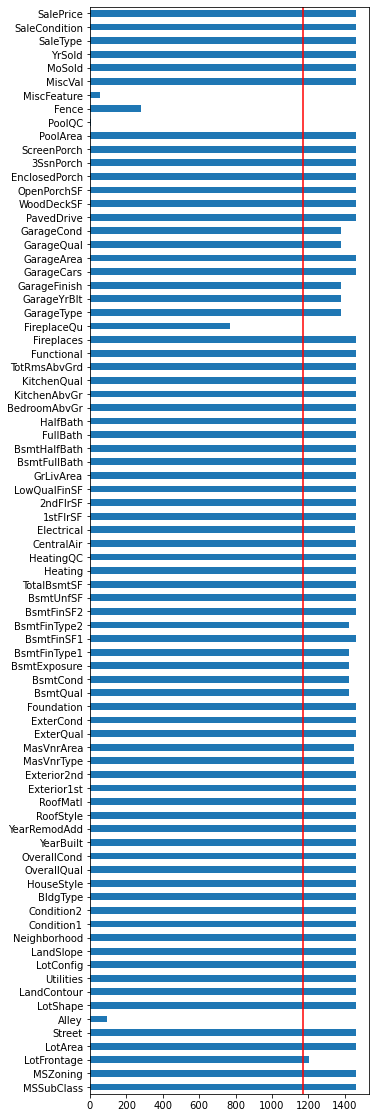

In [4]:
plt.figure(figsize=(5, 20))
train_data.count().plot.barh()
plt.axvline(x=(len(train_data) * 0.8), color='red')

### 2.3 Atributos categóricos e numéricos

Lista dos atributos categóricos `cat_features` e numéricos `num_features` de acordo com a descrição dos dados em `data_description.txt`.

In [5]:
cat_features = ['MSSubClass',
                'MSZoning',
                'Street',
                'Alley',
                'LotShape',
                'LandContour',
                'Utilities',
                'LotConfig',
                'LandSlope',
                'Neighborhood',
                'Condition1',
                'Condition2',
                'BldgType',
                'HouseStyle',
                'RoofStyle',
                'RoofMatl',
                'Exterior1st',
                'Exterior2nd',
                'MasVnrType',
                'ExterQual',
                'ExterCond',
                'Foundation',
                'BsmtQual',
                'BsmtCond',
                'BsmtExposure',
                'BsmtFinType1',
                'BsmtFinType2',
                'Heating',
                'HeatingQC',
                'CentralAir',
                'Electrical',
                'KitchenQual',
                'Functional',
                'FireplaceQu',
                'GarageType',
                'GarageFinish',
                'GarageQual',
                'GarageCond',
                'PavedDrive',
                'PoolQC',
                'Fence',
                'MiscFeature',
                'MoSold',
                'SaleType',
                'SaleCondition',
                'SalesPrice'
               ]

num_features = ['LotFrontage',
                'LotArea',
                'OverallQual',
                'OverallCond',
                'YearBuilt',
                'YearRemodAdd',
                'MasVnrArea',
                'BsmtFinSF1',
                'BsmtFinSF2',
                'BsmtUnfSF',
                'TotalBsmtSF',
                '1stFlrSF',
                '2ndFlrSF',
                'LowQualFinSF',
                'GrLivArea',
                'BsmtFullBath',
                'BsmtHalfBath',
                'FullBath',
                'HalfBath',
                'BedroomAbvGr',
                'KitchenAbvGr',
                'TotRmsAbvGrd',
                'Fireplaces',
                'GarageYrBlt',
                'GarageCars',
                'GarageArea',
                'WoodDeckSF',
                'OpenPorchSF',
                'EnclosedPorch',
                '3SsnPorch',
                'ScreenPorch',
                'PoolArea',
                'MiscVal',
                'YrSold'
               ]

### 2.4 Remoção das amostras

Remoção das amostras com dados ausentes no *Target*. 

`y_train` é uma *Series* da *Target* de treinamento, separada do *DataFrame* de treinamento.

In [6]:
train_data.dropna(subset='SalePrice', inplace=True)
y_train = train_data.pop('SalePrice')

### 2.5 Remoção dos atributos

Remoção dos atributos com a quantidade de dados `thresh` abaixo de 80% e atualização das listas dos atributos categóricos e numéricos.

In [7]:
thresh = int(len(train_data) * 0.8)
train_data = train_data.dropna(axis=1, thresh=thresh)
test_data = test_data[train_data.columns]

cat_features = [feature for feature in cat_features if feature in train_data.columns]
num_features = [feature for feature in num_features if feature in train_data.columns]

---
<a name="cleaning"></a>([Voltar ao Índice](#index))

## 3. Tratamentos e Transformações

### 3.1 Transformadores

`num_pipeline` são os passos para transformação dos atributos numéricos. Dados ausentes são preenchidos com o valor médio do atributo, e então cada atributo é padronizado com média zero e variância unitária.

`cat_pipeline` são os passos para transformação dos atributos categóricos. Dados ausentes são preenchidos com a categoria mais frequente do atributo, e então cada atributo é transformado em colunas binárias.

`col_transformer` é o transformador das colunas dos *DataFrames*.

In [8]:
num_pipeline = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

col_transformer = make_column_transformer(
    (num_pipeline, num_features), 
    (cat_pipeline, cat_features)
)

### 3.2 *DataFrames* de treinamento e teste

`X_train` é o *DataFrame* de treinamento com os atributos transformados.

`X_test` é o *DataFrame* de teste com os atributos transformados.

In [9]:
X_train = pd.DataFrame(
    data=col_transformer.fit_transform(train_data), 
    index=train_data.index, 
    columns=col_transformer.get_feature_names_out()
)

X_test = pd.DataFrame(
    data=col_transformer.transform(test_data), 
    index=test_data.index, 
    columns=col_transformer.get_feature_names_out()
)

---
<a name="training"></a>([Voltar ao Índice](#index))

## 4. Treinamentos e Validações

Técnicas utilizadas para criação dos modelos de regressão:
 - Random Forest Regressor
 - Gradient Boosting Regressor
 - XGB Regressor
 - Multi-layer Perceptron Regressor
 
Cada modelo será treinado usando a busca exaustiva `grid_search` sobre os valores dos parâmetros em `param_grid`, para obter o melhor resultado dos erros absolutos médios por meio da validação cruzada de 10 subconjuntos.

Descrição dos dicionários que serão utilizados:
 * `scores` guarda os erros absolutos médios de cada modelo.
 * `models` guarda os modelos com os melhores parâmetros encotrados.

In [10]:
scores = {}
models = {}

### 4.1 Modelo *Random Forest Regressor*

Treinando um modelo com *Random Forest Regressor*, que usa o método de *Bagging (bootstrap aggregating)*.

In [11]:
param_grid = {
    'n_estimators': [2500, 2600, 2700],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=10
)

submission['SalePrice'] = grid_search.fit(X_train, y_train).predict(X_test)
submission.to_csv('submission/rf_regressor.csv', index=False)

scores['Random Forest Regressor'] = -grid_search.best_score_
models['Random Forest Regressor'] = grid_search.best_estimator_
grid_search.best_params_

{'n_estimators': 2600}

### 4.2 Modelo *Gradient Boosting Regressor*

Modelo com *Gradient Boosting Regressor*, que usa o método de *Boosting (hypothesis boosting)*.

In [12]:
param_grid = {
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [300, 400, 500]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(n_iter_no_change=20, random_state=0),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=10
)

submission['SalePrice'] = grid_search.fit(X_train, y_train).predict(X_test)
submission.to_csv('submission/gb_regressor.csv', index=False)

scores['Gradient Boosting Regressor'] = -grid_search.best_score_
models['Gradient Boosting Regressor'] = grid_search.best_estimator_
grid_search.best_params_

{'learning_rate': 0.05, 'n_estimators': 400}

### 4.2 Modelo *XGB Regressor*

Modelo com *XGB Regressor* da biblioteca externa [XGBoost](https://xgboost.readthedocs.io), alternativa para *GB Regressor*.

Os *DataFrames* seguintes são utilizados para o treinamento. O modelo usa parâmetro extra para treinamento `fit_params` com um conjunto de *DataFrames* de validação.
* `X_train_` é o *DataFrame* de treinamento.
* `X_valid_` é o *DataFrame* de validação.
* `y_train_` é a *Series* da *Target* de treinamento.
* `y_valid_` é a *Series* da *Target* de validação.

In [13]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

param_grid = {
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [250, 300, 350]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(eval_metric='mae', early_stopping_rounds=20, random_state=0),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=10
)

fit_params = {
    'eval_set': [(X_valid_, y_valid_)],
    'verbose': False
}

submission['SalePrice'] = grid_search.fit(X_train_, y_train_, **fit_params).predict(X_test)
submission.to_csv('submission/xgb_regressor.csv', index=False)

scores['XGB Regressor'] = -grid_search.best_score_
models['XGB Regressor'] = grid_search.best_estimator_
grid_search.best_params_

{'learning_rate': 0.05, 'n_estimators': 300}

### 4.3 Modelo *Multi-layer Perceptron Regressor*

A função `model` retorna uma rede neural com número de entradas `input_shape`, número de camdas ocultas `n_hidden` e número de neurônios `n_neurons` para cada camada.

In [14]:
def model(input_shape, n_hidden, n_neurons):
    model = Sequential([InputLayer(input_shape=[input_shape])])
    for layer in range(n_hidden):
        model.add(Dense(units=n_neurons, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    return model

estimator = KerasRegressor(
    model=model, 
    model__input_shape=len(X_train.columns), 
    optimizer='adam', 
    loss='mae', 
    validation_split=0.1,
    callbacks=[EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)],
    verbose=0,
    random_state=0
)

param_grid = {
    'model__n_hidden': [5, 6, 7],
    'model__n_neurons': [140, 150, 160],
    'batch_size': [190, 200, 210],
    'epochs': [90, 100, 110]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=10
)

submission['SalePrice'] = grid_search.fit(X_train, y_train).predict(X_test)
submission.to_csv('submission/mlp_regressor.csv', index=False)

scores['MLP Regressor'] = -grid_search.best_score_
models['MLP Regressor'] = grid_search.best_estimator_
grid_search.best_params_

2022-08-06 20:43:06.536698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-08-06 20:56:54.244077: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-08-06 21:49:08.967628: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


{'batch_size': 200,
 'epochs': 100,
 'model__n_hidden': 6,
 'model__n_neurons': 150}

---
<a name="results"></a>([Voltar ao Índice](#index))

## 5. Resultados e Conclusão

### 5.1 Visualização dos resultados

Resultados dos erros absolutos médios dos modelos:
- O modelo treinado com *Multi-layer Perceptron Regressor* possui o melhor resultado.
- O modelo treinado com *Random Forest Regressor* possui o pior resultado.

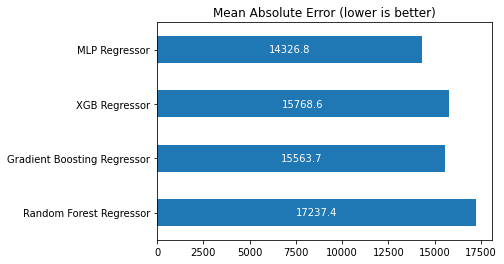

In [15]:
ax = pd.Series(scores).plot.barh(title='Mean Absolute Error (lower is better)')
ax.bar_label(ax.containers[0], label_type='center', color='white')
plt.show()

### 5.2 Submissão Final

A submissão final para a competição é através da média das predições dos 3 melhores modelos, com resultado final: **13161.99448**.

In [16]:
estimator = VotingRegressor(estimators=[
    ('gbr', models['Gradient Boosting Regressor']),
    ('xgb', models['XGB Regressor'].set_params(**{'early_stopping_rounds': None})),
    ('mlp', models['MLP Regressor'])
])

submission['SalePrice'] = estimator.fit(X_train, y_train).predict(X_test)
submission.to_csv('submission/voting_regressor.csv', index=False)

2022-08-06 21:58:36.034834: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmpc0zclos_/assets
